In [1]:
from pathlib import Path
import pdb
import os
import torch
import cv2
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import shutil
import json
from Bezier import bezier_curve
import math

%matplotlib inline

b8781f69-76c72b31
lane_num  7
splice_lane_num  5
reduced_lane_num  4


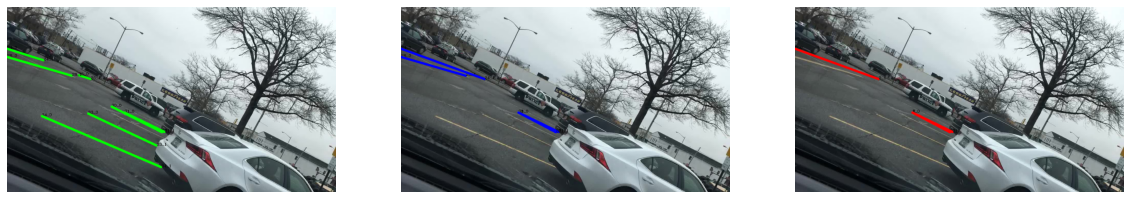

> <ipython-input-2-8ba8430d6554>(190)<module>()
    188 no_lane_num = 0
    189 sp_case = 0
--> 190 for img_name in all_list:
    191     #strip用于移除字符串头尾指定的字符x
    192     img_name = img_name.strip("\n")



In [ ]:
from pathlib import Path
import pdb
import os
import torch
import cv2
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import shutil
import json
from Bezier import bezier_curve
import math

%matplotlib inline
# 参数
# Pyten-20201022
save_path = "/home/pantengteng/datasets/bdd100k"
ignore_list = ["road curb", "crosswalk"]
show_img = True #True # True
save_img = False #False #False #  False
GRID_NUM = 100
DIST_NUM = 300
ANGLE_NUM = 2

# 画 点
def draw_point(img, lane_pt, text='', line_color=(255,0,0), text_color=(0, 0, 0)):
    # pdb.set_trace()
    for i in range(len(lane_pt)):
        pt = lane_pt[i]
        # 画圆，圆心为：(160, 160)，半径为：60，颜色为：point_color，实心线
        # cv2.circle(img, (int(pt[0]), int(pt[1])), 3, (0,0,255), 0)
        if text:
            #向图像上添加文本内容的函数(图片，添加的文字，左上角坐标，字体，字体大小，颜色，字体粗细)
            cv2.putText(img, text + "_%d"%i, (int(pt[0]), int(pt[1])), cv2.FONT_HERSHEY_COMPLEX, 0.5, text_color, 1)
        
        # 画线
        if i < len(lane_pt) - 1:
            next_pt = lane_pt[i + 1]
            #在图像中划线的函数(图片，起点，终点，颜色，线条粗细)
            cv2.line(img, (int(pt[0]), int(pt[1])), (int(next_pt[0]), int(next_pt[1])), line_color, 8, 2)
            
    return img

# 距 离
def dist(pset1, pset2):
    set2_down_pt = pset2[-1]
    set2_up_pt = pset2[0]
    set1_down_pt = pset1[-1]
    set1_up_pt = pset1[0]
    
    dis1 = math.sqrt((set1_down_pt[0] - set2_down_pt[0])**2 + (set1_down_pt[1] - set2_down_pt[1])**2)
    dis2 = math.sqrt((set1_up_pt[0] - set2_up_pt[0])**2 + (set1_up_pt[1] - set2_up_pt[1])**2)
    max_dis = max(dis1, dis2)
    return max_dis



# 长 度
def length(pset):
    set_down_pt = pset[-1]
    set_up_pt = pset[0]
    length = math.sqrt((set_down_pt[0] - set_up_pt[0])**2)
    return length

# 按车道线长度排序
def bubbleSort(lane_list):
    n = len(lane_list)
    for i in range(n):
        for j in range(0,n-i-1):
            length_1 = length(lane_list[j]["poly2d"])
            #print(length_1)
            length_2 = length(lane_list[j+1]["poly2d"])
            #print(length_2)
            #pdb.set_trace()
            if length_1 < length_2:
                temp = lane_list[j]
                lane_list[j] = lane_list[j+1]
                lane_list[j+1] = temp

def cal_angle(vec1, vec2):
    vec1_norm = math.sqrt(vec1[0]**2 + vec1[1]**2)
    vec2_norm = math.sqrt(vec2[0]**2 + vec2[1]**2)
    vec_dot = vec1[0]*vec2[0] + vec1[1]*vec2[1]
    try:
        cos = vec_dot / (vec1_norm * vec2_norm)
    except Exception as e:
        pdb.set_trace()
    degree = np.arccos(cos) * 180 / np.pi
    return degree

# 拼接时距离是否满足
def is_dist_close(pset1,pset2):
    if pset1[-1][1] < pset2[-1][1]:
        dist = math.sqrt((pset2[0][0]-pset1[-1][0])**2+(pset2[0][1]-pset1[-1][1])**2)
        # print(dist)
    else:
        dist = math.sqrt((pset1[0][0]-pset2[-1][0])**2+(pset1[0][1]-pset2[-1][1])**2)
        # print(dist)
    if dist < DIST_NUM:
        return True
    else:
        return False

# 拼接时角度是否满足
def is_angle_close(pset1,pset2):
    angle1 = cal_angle((pset1[-1][0] - pset1[0][0], pset1[-1][1] - pset1[0][1]), (10, 0))
    angle2 = cal_angle((pset2[-1][0] - pset2[0][0], pset2[-1][1] - pset2[0][1]), (10, 0))
    # print(angle1,angle2)
    if (angle1 - angle2)**2 < ANGLE_NUM:
        return True
    else:
        return False

# 返回两根待合并车道线的中间点
def add(obj1, obj2):
    pset1 = obj1["poly2d"]
    pset2 = obj2["poly2d"]
        
    if len(pset1) == len(pset2):
        r_set = []
        for i in range(len(pset1)):
            r_set.append([(pset1[i][0] + pset2[i][0]) / 2, (pset1[i][1] + pset2[i][1]) / 2])
            
    elif pset1[0][2] == "L" and pset1[-1][2] == "L" and pset2[0][2] == "L" and pset2[-1][2] == "L":
        r_set = [[(pset1[0][0] + pset2[0][0]) / 2, (pset1[0][1] + pset2[0][1]) / 2],
                  [(pset1[-1][0] + pset2[-1][0]) / 2, (pset1[-1][1] + pset2[-1][1]) / 2]]
    else:
        # 若C则BC化，所以这里只剩一种：即一L，一C
        if len(pset1) < len(pset2):
            pset1, pset2 = pset2, pset1
            
        x_arr = np.linspace(pset2[0][0], pset2[-1][0], num=GRID_NUM, endpoint=True)
        y_arr = np.linspace(pset2[0][1], pset2[-1][1], num=GRID_NUM, endpoint=True)

        r_set = []
        for i in range(len(pset1)):
            r_set.append([(pset1[i][0] + x_arr[i]) / 2, (pset1[i][1] + y_arr[i]) / 2])
        
    return r_set

# 拼接两根车道线
def splice_lane(obj1, obj2):
    pset1 = obj1["poly2d"]
    pset2 = obj2["poly2d"]
    if pset1[-1][1] < pset2[-1][1]:
        r_set = []
        r_set.append([pset1[0][0],pset1[0][1]])
        r_set.append([pset2[-1][0],pset2[-1][1]])
    else:
        r_set = []
        r_set.append([pset2[0][0],pset2[0][1]])
        r_set.append([pset1[-1][0],pset1[-1][1]])
    
    return r_set

def maybe_one_lane(cur_lane, another_lane):
    if (is_angle_close(cur_lane["poly2d"],another_lane["poly2d"]) and 
            is_dist_close(cur_lane["poly2d"],another_lane["poly2d"])):
        return True
    else:
        return False

def combine_two_lanes(cur_lane, another_lane):
    lane_pt = splice_lane(cur_lane, another_lane)
    cur_lane["poly2d"] = lane_pt
    return cur_lane


def maybe_same_lane(cur_lane, another_lane):
    if ( cur_lane["category"] == another_lane["category"] and
            cur_lane["attributes"] == another_lane["attributes"] ):
        return True
    else:
        return False

# 注意：会改变原始的列表
def combine_same_lane(cur_lane, another_lane):
    lane_pt = add(cur_lane, another_lane)
    cur_lane["poly2d"] = lane_pt
    return cur_lane
  
# Pyten-20201022
with open(save_path + "/val.txt", "r") as f:
    all_list = f.readlines()

max_lane_num = 0
total_num = 0
no_lane_num = 0
sp_case = 0
for img_name in all_list:
    #strip用于移除字符串头尾指定的字符x
    img_name = img_name.strip("\n")
    print(img_name) 
    #img_name = "c223e6d7-e1a9bb5a"
    #img_name = 'b73282b1-7bc49185'
    #img_name = "c8ffbba5-334918b7"
    
    img_name = 'bef1fe5a-2384bb3d'
    if Path(f"{save_path}/test_label/{img_name}.png").exists():
        print("exist!")
        continue
    img = cv2.imread(save_path + "/images/100k/val/" + img_name + ".jpg")
    img1 = img.copy()
    img2 = img.copy()
    img3 = img.copy()
    label_file = save_path + "/labels/100k/val/" + img_name + ".json"
    with open(label_file, encoding="utf-8") as f:
         label_dic = json.load(f)
    
    # 筛选出需要的lane
    same_line_flg = False
    objs = label_dic["frames"][0]["objects"]
    obj_index = 0
    lane_list = []
    while obj_index < len(objs):
        # pdb.set_trace()
        obj = objs[obj_index]
        if "lane" in obj["category"]:
            # 过滤车道线类型
            if (obj["category"][5:] in ignore_list) or (obj["attributes"]["direction"] != "parallel"):
                obj_index += 1
                continue
            # 按照y更新点的顺序，起点在远端
            lane_pt = obj["poly2d"]

            # BC曲线控制点转换为点集
            if len(lane_pt) > 2:
                # pdb.set_trace()
                if lane_pt[0][2] != "C" and lane_pt[-1][2] != "C":
                    print("More than 3 points but not Bezier curve!")
                    print(obj["id"])
                    sp_case += 1
                # print("Convert Bezier curve!")
                xvals, yvals = bezier_curve(lane_pt, nTimes=GRID_NUM)
                obj["poly2d"] = [[xvals[i], yvals[i], "C"] for i in range(len(xvals))]

            obj["poly2d"].sort(key=lambda x:x[1])
        
            #计算与水平方向的夹角(x的差值，y的差值)
            angle = cal_angle((obj["poly2d"][-1][0] - obj["poly2d"][0][0], obj["poly2d"][-1][1] - obj["poly2d"][0][1]), (10, 0))

            if angle < 5 or angle > 175:
                obj_index += 1
                continue
            
            #img1 = draw_point(img1, obj["poly2d"], str(obj["id"]), line_color=(0, 255, 0))
            lane_list.append(obj)
        obj_index += 1
    
    # 合并双线
    combined_lane_list = []
    lane_index = 0
    while lane_index < len(lane_list):
        left_index = lane_index + 1
        min_distance = 100 # float('inf')
        min_index = lane_index
        # 每条线只能融合一次，最小
        while left_index < len(lane_list):
            cur_lane = lane_list[lane_index]
            another_lane = lane_list[left_index]
            if maybe_same_lane(cur_lane, another_lane):
                # pdb.set_trace()
                cur_distance = dist(cur_lane["poly2d"], another_lane["poly2d"])
                if min_distance > cur_distance:
                    min_distance = cur_distance
                    min_index = left_index
            left_index += 1
        if min_index != lane_index:
            lane_list[lane_index] = combine_same_lane(lane_list[lane_index], lane_list[min_index])
            lane_list.pop(min_index)

        combined_lane_list.append(lane_list[lane_index])
        lane_index += 1
        for lane in combined_lane_list:
            img1 = draw_point(img1, lane["poly2d"], str(lane["id"]), line_color=(0, 255, 0))
  

    lane_num = len(combined_lane_list)
    total_num += lane_num
    if lane_num == 0:
        no_lane_num += 1
    else:
        with open(save_path + "/all_with_lane.txt", "a") as f:
            f.write(img_name + "\n")
    print("lane_num ", lane_num)
    if max_lane_num < lane_num:
        max_lane_num = lane_num
    
    
    # 合并被拆分的车道线
    splice_lane_list = combined_lane_list[:]
    splice_lane_num = 0
    if len(combined_lane_list) > 0:
        for i in range(len(splice_lane_list)-1):
            for j in range(i+1,len(splice_lane_list)):
                cur_lane = combined_lane_list[i]
                another_lane = combined_lane_list[j]
                if maybe_one_lane(cur_lane, another_lane):
                    # pdb.set_trace()
                    splice_lane_list.pop(j)
                    splice_lane_list.pop(i)
                    splice_lane_list.append(combine_two_lanes(cur_lane,another_lane))
        for lane in splice_lane_list:
            img3 = draw_point(img3, lane["poly2d"], str(lane["id"]), line_color=(255, 0, 0))
            splice_lane_num += 1
    print("splice_lane_num ",splice_lane_num)
                
    
    
    # Pyten-20201013-SetLaneNumTo4
    # 根据近端y坐标排序
    combined_lane_list = sorted(combined_lane_list, key=lambda x:x["poly2d"][-1][1], reverse=True)
    splice_lane_list = sorted(splice_lane_list, key=lambda x:x["poly2d"][-1][1], reverse=True)
    combined_lane_list1 = splice_lane_list[:4]
    lane_list = combined_lane_list[:]
    #print(lane_list)
    bubbleSort(lane_list)
    #print(lane_list)
    combined_lane_list = combined_lane_list[:4]
    bubbleSort(combined_lane_list)
    if len(lane_list) > 4:  
        if lane_list[0] not in combined_lane_list:
            combined_lane_list.insert(0,lane_list[0])
            combined_lane_list = combined_lane_list[:4]
        #if lane_list[1] not in combined_lane_list 
        #    combined_lane_list.insert(1,lane_list[1])
        #    combined_lane_list = combined_lane_list[:4]
    
    lane_new_num = len(combined_lane_list1)
    print("reduced_lane_num ", lane_new_num)
        
    
    # 重新排列
    # 依据远端点x坐标进行排序
    combined_lane_list = sorted(combined_lane_list, key=lambda x:x["poly2d"][0][0])
    combined_lane_list1 = sorted(combined_lane_list1, key=lambda x:x["poly2d"][0][0])
    
    
    # 可视化
    # 转换label
    label = np.zeros((img.shape[0], img.shape[1]))
    # pdb.set_trace()
    
    
    for idx,lane in enumerate(combined_lane_list):
        # Pyten-20201022
        img = draw_point(img, lane["poly2d"], str(idx), line_color=(0,0,255 ))
        #label = draw_point(label, lane["poly2d"], line_color=idx+1)
    
    for idx,lane in enumerate(combined_lane_list1):
        # Pyten-20201022
        img2 = draw_point(img2, lane["poly2d"], str(idx), line_color=(0,0,255))
        #label = draw_point(label, lane["poly2d"], line_color=idx+1)
    
    if save_img:
        cv2.imwrite(f"{save_path}/test_label/{img_name}.png", label)
        
    if show_img:
        if splice_lane_num != lane_num: # and combined_lane_list1 != combined_lane_list:
            img = img[:,:,::-1] #按y值和车道线长度排序前四条
            img1 = img1[:,:,::-1] #原车道线
            img2 = img2[:,:,::-1] #按y值排序前四条
            img3 = img3[:,:,::-1] #连接车道线
            plt.figure(figsize=(20,10))
            plt.subplot(1,3,1)
            plt.imshow(img1)
            plt.axis("off")
            plt.subplot(1,3,2)
            plt.imshow(img3)
            plt.axis("off")
            plt.subplot(1,3,3)
            plt.imshow(img2)
            plt.axis("off")
            plt.show()
            pdb.set_trace()
print("max_lane_num", max_lane_num)
print("avg_num", total_num/len(all_list))
print("no_lane_num", no_lane_num)
print("sp_case:", sp_case)